In [1]:
#adapted from plotRegrsFromGAE_starmap.ipynb
import sys
sys.path.append('/home/xinyiz/pamrats')

In [7]:
##This is adapted from https://github.com/tkipf/gae/blob/master/gae/train.py and https://github.com/tkipf/pygcn/blob/master/pygcn/train.py##

import time
import os

# Train on CPU (hide GPU) due to memory constraints
# os.environ['CUDA_VISIBLE_DEVICES'] = ""

import scanpy
import numpy as np
import scipy.sparse as sp

import torch
from torch import optim
from torch.utils.data import DataLoader
# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import average_precision_score

import image.loadImage as loadImage
import gae.gae.optimizer as optimizer
import gae.gae.model
import gae.gae.preprocessing as preprocessing
import image.modelsCNN as modelsCNN

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.colors
from sklearn.preprocessing import MinMaxScaler
import anndata as ad
from sklearn.metrics import pairwise_distances

In [3]:
imageSizes={}
imageSizes['disease13']=(22210, 22344)
imageSizes['control13']=(22355, 18953)
imageSizes['disease8']=(22294, 19552)
imageSizes['control8']=(22452, 19616)

plaqueMaskName='PlaqueMask6'
plaqueMaskImg='Maskofplaque6.tif'
lossThreshSize=1111
hiddendim=6000
useSavedMaskedEdges=True
use_cuda=True

In [5]:
datadir='/home/xinyiz/2021-01-13-mAD-test-dataset'

gaeClusterPath='/mnt/external_ssd/xinyi/plots/train_gae_starmap/allk20XA_02_dca_over/combinedlogminmax_beforeAct/cluster/leiden_nn10mdist025n_pcs40res0.1epoch9990'
with open(gaeClusterPath, 'rb') as input:
    gaeclusterlabels = pickle.load(input)

plot_samples={'disease13':'AD_mouse9494','control13':'AD_mouse9498','disease8':'AD_mouse9723','control8':'AD_mouse9735'}

gaeCoord=None
sampleNames=None
scaleddata=scanpy.read_h5ad(datadir+'/2020-12-27-starmap-mAD-raw.h5ad')
for s in plot_samples.keys():
    sampleidx_s=plot_samples[s] 
    if gaeCoord is None:
        gaeCoord=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx_s,['y','x']].to_numpy()
        sampleNames=np.repeat(s,np.sum(scaleddata.obs['sample']==sampleidx_s))
    else:
        gaeCoord=np.concatenate((gaeCoord,scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx_s,['y','x']].to_numpy()),axis=0)
        sampleNames=np.concatenate((sampleNames,np.repeat(s,np.sum(scaleddata.obs['sample']==sampleidx_s))),axis=None)
gaeCoord=(gaeCoord/0.3).astype(int)
feature_names=scaleddata.var.index
feature_names=feature_names.astype(str)


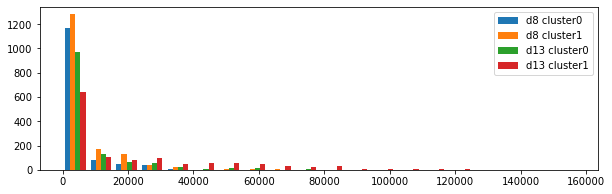

In [8]:
c0='0'
c1='1'
s8='disease8'
s13='disease13'
idx08=gaeclusterlabels[sampleNames==s8]==c0
idx18=gaeclusterlabels[sampleNames==s8]==c1
idx013=gaeclusterlabels[sampleNames==s13]==c0
idx113=gaeclusterlabels[sampleNames==s13]==c1
res=[labellist[s8][idx08],labellist[s8][idx18],labellist[s13][idx013],labellist[s13][idx113]]
plt.rcParams["figure.figsize"] = (10,3)
numbers=plt.hist(res,20)
plt.legend(['d8 cluster0','d8 cluster1','d13 cluster0','d13 cluster1'])
plt.savefig('/mnt/external_ssd/xinyi/plots/data/plaqueDistr.tif',dpi=300)

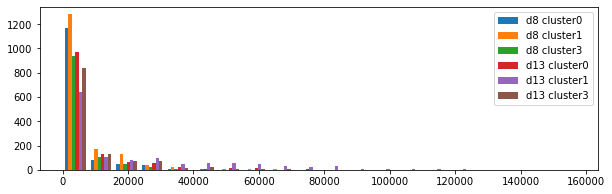

In [6]:
c0='0'
c1='1'
c3='3'
s8='disease8'
s13='disease13'
idx08=gaeclusterlabels[sampleNames==s8]==c0
idx18=gaeclusterlabels[sampleNames==s8]==c1
idx38=gaeclusterlabels[sampleNames==s8]==c3
idx013=gaeclusterlabels[sampleNames==s13]==c0
idx113=gaeclusterlabels[sampleNames==s13]==c1
idx313=gaeclusterlabels[sampleNames==s13]==c3
res=[labellist[s8][idx08],labellist[s8][idx18],labellist[s8][idx38],labellist[s13][idx013],labellist[s13][idx113],labellist[s13][idx313]]
plt.rcParams["figure.figsize"] = (10,3)
numbers=plt.hist(res,20)
plt.legend(['d8 cluster0','d8 cluster1','d8 cluster3','d13 cluster0','d13 cluster1','d13 cluster3'])

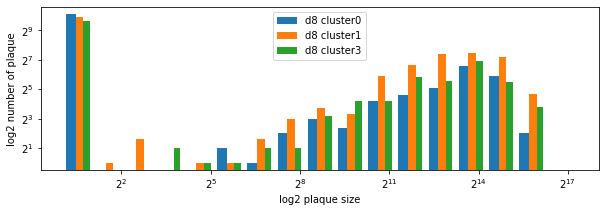

In [35]:
c0='0'
c1='1'
c3='3'
s8='disease8'
# s13='disease13'
idx08=gaeclusterlabels[sampleNames==s8]==c0
idx18=gaeclusterlabels[sampleNames==s8]==c1
idx38=gaeclusterlabels[sampleNames==s8]==c3
# idx013=gaeclusterlabels[sampleNames==s13]==c0
# idx113=gaeclusterlabels[sampleNames==s13]==c1
res=[list(np.array(labellist[s8][idx08])+1),list(np.array(labellist[s8][idx18])+1),list(np.array(labellist[s8][idx38])+1)]
plt.rcParams["figure.figsize"] = (10,3)
# numbers=plt.hist(res,20)
plt.xscale('log',base=2)
plt.yscale('log',base=2)
numbers=plt.hist(res,bins=np.logspace(np.log2(1),np.log2(np.max(np.concatenate((labellist['disease8'],labellist['disease13'])))),18,base=2))
plt.legend(['d8 cluster0','d8 cluster1','d8 cluster3'])
plt.xlabel('log2 plaque size')
plt.ylabel('log2 number of plaque')
plt.savefig('/mnt/external_ssd/xinyi/plots/data/plaqueDistr_log_d8_wc3.tif',dpi=300)

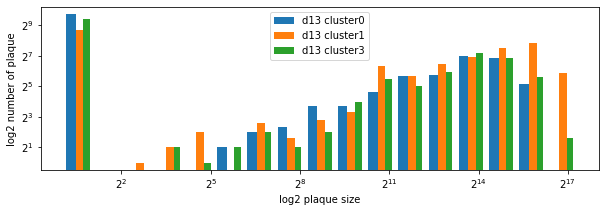

In [36]:
c0='0'
c1='1'
c3='3'
# s8='disease8'
s13='disease13'
# idx08=gaeclusterlabels[sampleNames==s8]==c0
# idx18=gaeclusterlabels[sampleNames==s8]==c1
idx013=gaeclusterlabels[sampleNames==s13]==c0
idx113=gaeclusterlabels[sampleNames==s13]==c1
idx313=gaeclusterlabels[sampleNames==s13]==c3
res=[list(np.array(labellist[s13][idx013])+1),list(np.array(labellist[s13][idx113])+1),list(np.array(labellist[s13][idx313])+1)]
plt.rcParams["figure.figsize"] = (10,3)
# numbers=plt.hist(res,20)
plt.xscale('log',base=2)
plt.yscale('log',base=2)
numbers=plt.hist(res,bins=np.logspace(np.log2(1),np.log2(np.max(np.concatenate((labellist['disease8'],labellist['disease13'])))),18,base=2))
plt.legend(['d13 cluster0','d13 cluster1','d13 cluster3'])
plt.xlabel('log2 plaque size')
plt.ylabel('log2 number of plaque')
plt.savefig('/mnt/external_ssd/xinyi/plots/data/plaqueDistr_log_d13_wc3.tif',dpi=300)

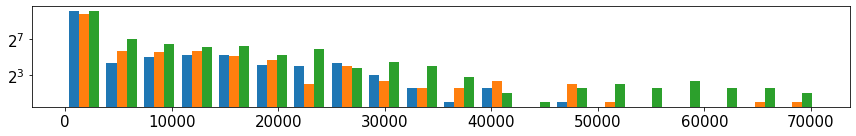

In [27]:
c0='0'
c1='1'
c3='3'
s8='disease8'
# s13='disease13'
idx08=gaeclusterlabels[sampleNames==s8]==c0
idx18=gaeclusterlabels[sampleNames==s8]==c1
idx38=gaeclusterlabels[sampleNames==s8]==c3
# idx013=gaeclusterlabels[sampleNames==s13]==c0
# idx113=gaeclusterlabels[sampleNames==s13]==c1
res=[list(np.array(labellist[s8][idx08])+1),list(np.array(labellist[s8][idx38])+1),list(np.array(labellist[s8][idx18])+1)]
plt.rcParams["figure.figsize"] = (12,2)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
# numbers=plt.hist(res,20)
plt.yscale('log',base=2)
numbers=plt.hist(res,bins=20)
# plt.legend(['cluster 1','cluster 2','cluster 3'])
# plt.xlabel('plaque size')
# plt.ylabel('log2 number of plaque')
plt.tight_layout()
plt.savefig('/mnt/external_ssd/xinyi/plots/data/plaqueDistr_logy_d8_wc3.tif',dpi=300)

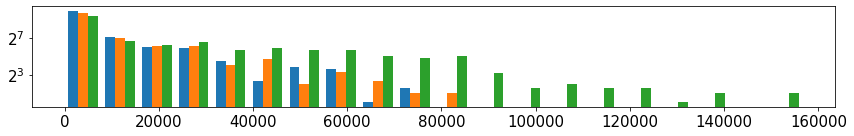

In [28]:
c0='0'
c1='1'
c3='3'
# s8='disease8'
s13='disease13'
# idx08=gaeclusterlabels[sampleNames==s8]==c0
# idx18=gaeclusterlabels[sampleNames==s8]==c1
idx013=gaeclusterlabels[sampleNames==s13]==c0
idx113=gaeclusterlabels[sampleNames==s13]==c1
idx313=gaeclusterlabels[sampleNames==s13]==c3
res=[list(np.array(labellist[s13][idx013])+1),list(np.array(labellist[s13][idx313])+1),list(np.array(labellist[s13][idx113])+1)]
plt.rcParams["figure.figsize"] = (12,2)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)
# numbers=plt.hist(res,20)
# plt.xscale('log',base=2)
plt.yscale('log',base=2)
numbers=plt.hist(res,bins=20)
# plt.legend(['cluster 1','cluster 2','cluster 3'])
# plt.xlabel('plaque size')
# plt.ylabel('log2 number of plaque')
plt.tight_layout()
plt.savefig('/mnt/external_ssd/xinyi/plots/data/plaqueDistr_logy_d13_wc3.tif',dpi=300)

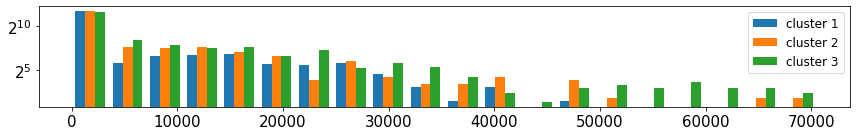

In [40]:
c0='0'
c1='1'
c3='3'
a0=215897
a1= 236653
a3= 166213
areasum=a0+a1+a3
a0=(areasum)/a0
a1=(areasum)/a1
a3=(areasum)/a3
s8='disease8'
# s13='disease13'
idx08=gaeclusterlabels[sampleNames==s8]==c0
idx18=gaeclusterlabels[sampleNames==s8]==c1
idx38=gaeclusterlabels[sampleNames==s8]==c3
# idx013=gaeclusterlabels[sampleNames==s13]==c0
# idx113=gaeclusterlabels[sampleNames==s13]==c1
res=[list(np.array(labellist[s8][idx08])+1),list(np.array(labellist[s8][idx38])+1),list(np.array(labellist[s8][idx18])+1)]
plt.rcParams["figure.figsize"] = (12,2)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
# numbers=plt.hist(res,20)
plt.yscale('log',base=2)
numbers8=plt.hist(res,bins=20,weights=[list(np.repeat(a0,np.array(labellist[s8][idx08]).size)),list(np.repeat(a3,np.array(labellist[s8][idx38]).size)),list(np.repeat(a1,np.array(labellist[s8][idx18]).size))])
plt.legend(['cluster 1','cluster 2','cluster 3'],fontsize=12)
# plt.xlabel('plaque size')
# plt.ylabel('log2 number of plaque')
plt.tight_layout()
plt.savefig('/mnt/external_ssd/xinyi/plots/data/plaqueDistr_logy_d8_wc3_areaNorm.tif',dpi=300)

In [87]:
diamThresh_mul=800
minThresh_mul=12
overlap=int(diamThresh_mul*0.7)
areaThresh=diamThresh_mul*diamThresh_mul*0.7


sampleidx={'disease13':'AD_mouse9494','control13':'AD_mouse9498','disease8':'AD_mouse9723','control8':'AD_mouse9735'}
cellCoord={}
for s in sampleidx.keys():
    sampleidx_s=sampleidx[s] 
    cellCoord[s]=((scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx_s,['y','x']].to_numpy())/0.3).astype(int)


labellist={}
for s in sampleidx.keys():
    print(s)
    
    if 'disease' in s:
        plaqueMaskImg_s=plaqueMaskImg
    elif 'control' in s:
        plaqueMaskImg_s=None
    imgInputnp,labellist[s]=loadImage.load_cellCentroid_plaque(plaqueMaskImg_s,cellCoord[s],sampleidx[s],datadir,diamThresh_mul,ifFlip=False,seed=3,imagename='pi_sum.tif',minmaxscale=True,nchannels=1)
    imgInputnp=None

disease13
(22210, 22344)
control13
(22355, 18953)
disease8
(22294, 19552)
control8
(22452, 19616)


In [86]:
import gc
gc.collect()

77064

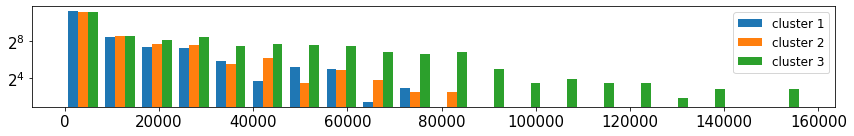

In [88]:
#corrected area; previous version used d8 area
c0='0'
c1='1'
c3='3'
a0=209790
a1= 149957
a3= 190885
areasum=a0+a1+a3
a0=(areasum)/a0
a1=(areasum)/a1
a3=(areasum)/a3
# s8='disease8'
s13='disease13'
# idx08=gaeclusterlabels[sampleNames==s8]==c0
# idx18=gaeclusterlabels[sampleNames==s8]==c1
idx013=gaeclusterlabels[sampleNames==s13]==c0
idx113=gaeclusterlabels[sampleNames==s13]==c1
idx313=gaeclusterlabels[sampleNames==s13]==c3
res=[list(np.array(labellist[s13][idx013])+1),list(np.array(labellist[s13][idx313])+1),list(np.array(labellist[s13][idx113])+1)]
plt.rcParams["figure.figsize"] = (12,2)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)
# numbers=plt.hist(res,20)
# plt.xscale('log',base=2)
plt.yscale('log',base=2)
numbers13=plt.hist(res,bins=20,weights=[list(np.repeat(a0,np.array(labellist[s13][idx013]).size)),list(np.repeat(a3,np.array(labellist[s13][idx313]).size)),list(np.repeat(a1,np.array(labellist[s13][idx113]).size))])
plt.legend(['cluster 1','cluster 2','cluster 3'],fontsize=12)
# plt.xlabel('plaque size')
# plt.ylabel('log2 number of plaque')
plt.tight_layout()
plt.savefig('/mnt/external_ssd/xinyi/plots/data/plaqueDistr_logy_d13_wc3_areaNorm.tif',dpi=300)

In [24]:
np.log2(np.max(np.concatenate((labellist['disease8'],labellist['disease13']))))

17.256512781427737

In [36]:
import scipy.stats

In [47]:
numbers8[1]

array([1.000000e+00, 3.525950e+03, 7.050900e+03, 1.057585e+04,
       1.410080e+04, 1.762575e+04, 2.115070e+04, 2.467565e+04,
       2.820060e+04, 3.172555e+04, 3.525050e+04, 3.877545e+04,
       4.230040e+04, 4.582535e+04, 4.935030e+04, 5.287525e+04,
       5.640020e+04, 5.992515e+04, 6.345010e+04, 6.697505e+04,
       7.050000e+04])

In [49]:
scipy.stats.ttest_rel(numbers8[0][0][1:].flatten(),numbers8[0][2][1:].flatten(),alternative='less')

Ttest_relResult(statistic=-2.727205561138928, pvalue=0.006914048671314312)

In [89]:
scipy.stats.ttest_ind(labellist[s13][idx013],labellist[s13][idx113])

Ttest_indResult(statistic=-18.0333092774563, pvalue=1.7419026860981267e-68)

In [90]:
scipy.stats.ttest_ind(labellist[s13][idx013],labellist[s13][idx313])

Ttest_indResult(statistic=-2.7395043090669047, pvalue=0.006197622633723589)

In [50]:
scipy.stats.ttest_ind(labellist[s8][idx08],labellist[s8][idx18])

Ttest_indResult(statistic=-9.2751594104501, pvalue=3.283175554723873e-20)

In [56]:
scipy.stats.ttest_ind(labellist[s8][idx08],labellist[s8][idx38])

Ttest_indResult(statistic=-3.5301949560973465, pvalue=0.0004228077346633263)

In [12]:
s8='disease8'


plaqueStats=pd.read_csv(os.path.join(datadir,plot_samples[s8],'trimmed_images',plaqueMaskName+'.csv'),index_col=0)



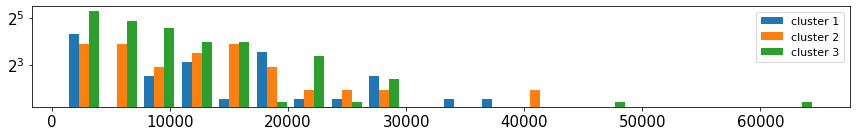

In [100]:
# assign plaque to cluster by the nearest cell

s8='disease8'
plaqueStats=pd.read_csv(os.path.join(datadir,plot_samples[s8],'trimmed_images',plaqueMaskName+'.csv'))
plaqueCoord=plaqueStats.loc[:,('Y','X')].to_numpy()
plaqueSize8=plaqueStats.loc[:,'Area'].to_numpy()
cell2plaque=pairwise_distances(plaqueCoord,gaeCoord[sampleNames==s8],n_jobs=-1)
nearestCell=np.argmin(cell2plaque,axis=1)
nearestCell_label8=gaeclusterlabels[sampleNames==s8][nearestCell]


c0='0'
c1='1'
c3='3'
a0=215897
a1= 236653
a3= 166213
areasum=a0+a1+a3
a0=(areasum)/a0
a1=(areasum)/a1
a3=(areasum)/a3

# s13='disease13'
# idx08=gaeclusterlabels[sampleNames==s8]==c0
# idx18=gaeclusterlabels[sampleNames==s8]==c1
# idx38=gaeclusterlabels[sampleNames==s8]==c3
res=[list(plaqueSize8[nearestCell_label8==c0]),list(plaqueSize8[nearestCell_label8==c3]),list(plaqueSize8[nearestCell_label8==c1])]
plt.rcParams["figure.figsize"] = (12,2)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
# numbers=plt.hist(res,20)
plt.yscale('log',base=2)
numbers8=plt.hist(res,bins=20,weights=[list(np.repeat(a0,np.sum(nearestCell_label8==c0))),list(np.repeat(a3,np.sum(nearestCell_label8==c3))),list(np.repeat(a1,np.sum(nearestCell_label8==c1)))])
plt.legend(['cluster 1','cluster 2','cluster 3'],fontsize=11)
# plt.xlabel('plaque size')
# plt.ylabel('log2 number of plaque')
plt.tight_layout()
plt.savefig('/mnt/external_ssd/xinyi/plots/data/plaqueDistr_plaqueCount_logy_d8_wc3_areaNorm.tif',dpi=300)

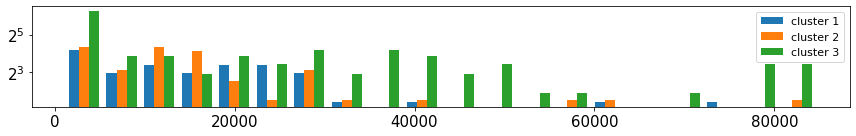

In [98]:
# assign plaque to cluster by the nearest cell

s13='disease13'
plaqueStats=pd.read_csv(os.path.join(datadir,plot_samples[s13],'trimmed_images',plaqueMaskName+'.csv'))
plaqueCoord=plaqueStats.loc[:,('Y','X')].to_numpy()
plaqueSize13=plaqueStats.loc[:,'Area'].to_numpy()
cell2plaque=pairwise_distances(plaqueCoord,gaeCoord[sampleNames==s13],n_jobs=-1)
nearestCell=np.argmin(cell2plaque,axis=1)
nearestCell_label13=gaeclusterlabels[sampleNames==s13][nearestCell]


c0='0'
c1='1'
c3='3'
a0=209790
a1= 149957
a3= 190885
areasum=a0+a1+a3
a0=(areasum)/a0
a1=(areasum)/a1
a3=(areasum)/a3

# s13='disease13'
# idx013=gaeclusterlabels[sampleNames==s13]==c0
# idx113=gaeclusterlabels[sampleNames==s13]==c1
# idx313=gaeclusterlabels[sampleNames==s13]==c3
res=[list(plaqueSize13[nearestCell_label13==c0]),list(plaqueSize13[nearestCell_label13==c3]),list(plaqueSize13[nearestCell_label13==c1])]
plt.rcParams["figure.figsize"] = (12,2)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
# numbers=plt.hist(res,20)
plt.yscale('log',base=2)
numbers13=plt.hist(res,bins=20,weights=[list(np.repeat(a0,np.sum(nearestCell_label13==c0))),list(np.repeat(a3,np.sum(nearestCell_label13==c3))),list(np.repeat(a1,np.sum(nearestCell_label13==c1)))])
plt.legend(['cluster 1','cluster 2','cluster 3'],fontsize=11)
# plt.xlabel('plaque size')
# plt.ylabel('log2 number of plaque')
plt.tight_layout()
plt.savefig('/mnt/external_ssd/xinyi/plots/data/plaqueDistr_plaqueCount_logy_d13_wc3_areaNorm.tif',dpi=300)

In [45]:
numbers13[0]

array([[20.06207127,  8.59803054, 11.46404072,  8.59803054, 11.46404072,
        11.46404072,  8.59803054,  2.86601018,  0.        ,  2.86601018,
         0.        ,  0.        ,  0.        ,  0.        ,  2.86601018,
         0.        ,  0.        ,  2.86601018,  0.        ,  0.        ],
       [26.05897854, 11.16813366, 26.05897854, 22.33626732,  7.44542244,
         3.72271122, 11.16813366,  3.72271122,  0.        ,  3.72271122,
         0.        ,  0.        ,  0.        ,  3.72271122,  3.72271122,
         0.        ,  0.        ,  0.        ,  0.        ,  3.72271122],
       [54.90749325, 10.45857014, 10.45857014,  5.22928507, 10.45857014,
         7.84392761, 13.07321268,  5.22928507, 13.07321268, 10.45857014,
         5.22928507,  7.84392761,  2.61464254,  2.61464254,  0.        ,
         0.        ,  2.61464254,  0.        ,  7.84392761,  7.84392761]])

In [49]:
numbers13[0][0][1:]

array([ 8.59803054, 11.46404072,  8.59803054, 11.46404072, 11.46404072,
        8.59803054,  2.86601018,  0.        ,  2.86601018,  0.        ,
        0.        ,  0.        ,  0.        ,  2.86601018,  0.        ,
        0.        ,  2.86601018,  0.        ,  0.        ])

In [76]:
scipy.stats.ttest_ind(plaqueSize8[nearestCell_label8==c0],plaqueSize8[nearestCell_label8==c1],alternative='less')

Ttest_indResult(statistic=1.1731828900747843, pvalue=0.8778536718824896)

In [79]:
scipy.stats.ttest_ind(plaqueSize8[nearestCell_label8==c0],plaqueSize8[nearestCell_label8==c3],alternative='less')

Ttest_indResult(statistic=0.4371199055120024, pvalue=0.6679188315573681)

In [63]:
scipy.stats.ttest_ind(numbers8[0][0][:].flatten(),numbers8[0][2][:].flatten(),alternative='less')

Ttest_indResult(statistic=-1.488472467647071, pvalue=0.07243951191154853)

In [69]:
scipy.stats.ttest_ind(numbers8[0][0][:].flatten(),numbers8[0][1][:].flatten(),alternative='less')

Ttest_indResult(statistic=-0.5825000276969583, pvalue=0.28183528125025226)

In [92]:
scipy.stats.ttest_ind(plaqueSize13[nearestCell_label13==c0],plaqueSize13[nearestCell_label13==c1],alternative='less')

Ttest_indResult(statistic=-1.4390947642734475, pvalue=0.07665503384320799)

In [93]:
scipy.stats.ttest_ind(plaqueSize13[nearestCell_label13==c0],plaqueSize13[nearestCell_label13==c3],alternative='less')

Ttest_indResult(statistic=0.05458560112391397, pvalue=0.5216806738872688)

In [94]:
scipy.stats.ttest_ind(numbers13[0][0][:].flatten(),numbers13[0][2][:].flatten(),alternative='less')

Ttest_indResult(statistic=-2.161587566348402, pvalue=0.018507388919035143)

In [95]:
scipy.stats.ttest_ind(numbers13[0][0][:].flatten(),numbers13[0][1][:].flatten(),alternative='less')

Ttest_indResult(statistic=-0.36747944471284777, pvalue=0.3576501236804285)

In [101]:
np.save('/mnt/external_ssd/xinyi/plots/data/plaqueSize8c0.npy',plaqueSize8[nearestCell_label8==c0])

In [102]:
np.save('/mnt/external_ssd/xinyi/plots/data/plaqueSize8c3.npy',plaqueSize8[nearestCell_label8==c3])
np.save('/mnt/external_ssd/xinyi/plots/data/plaqueSize8c1.npy',plaqueSize8[nearestCell_label8==c1])

In [103]:
np.save('/mnt/external_ssd/xinyi/plots/data/plaqueSize13c0.npy',plaqueSize13[nearestCell_label13==c0])
np.save('/mnt/external_ssd/xinyi/plots/data/plaqueSize13c3.npy',plaqueSize13[nearestCell_label13==c3])
np.save('/mnt/external_ssd/xinyi/plots/data/plaqueSize13c1.npy',plaqueSize13[nearestCell_label13==c1])